start with loading the libraries we need and load the dataset from an uploaded file
(red first, then white)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
import io

uploaded1 = files.upload()
red = pd.read_csv(io.BytesIO(uploaded1['winequality-red.csv']), sep=";")
uploaded2 = files.upload()
white = pd.read_csv(io.BytesIO(uploaded2['winequality-white.csv']), sep=";")

Saving winequality-red.csv to winequality-red.csv


Saving winequality-white.csv to winequality-white.csv


I want to see if I can predict red vs white wine - so I'm going to add an extra binary feature to both datasets then join them

In [0]:
print(red.info(),white.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column        

we can see the features in the 2 datasets are the same, so we can add the 'type' feature (0 denoting a white wine, 1 denoting red)

In [0]:
white['type']=0
red['type']=1 

I'm only taking the first 1599 white wine entries because if I took them all there would be more than 3x the number of white wines compared to red

In [0]:
train = pd.concat([red, white[:1599]])

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3198 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3198 non-null   float64
 1   volatile acidity      3198 non-null   float64
 2   citric acid           3198 non-null   float64
 3   residual sugar        3198 non-null   float64
 4   chlorides             3198 non-null   float64
 5   free sulfur dioxide   3198 non-null   float64
 6   total sulfur dioxide  3198 non-null   float64
 7   density               3198 non-null   float64
 8   pH                    3198 non-null   float64
 9   sulphates             3198 non-null   float64
 10  alcohol               3198 non-null   float64
 11  quality               3198 non-null   int64  
 12  type                  3198 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 349.8 KB


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


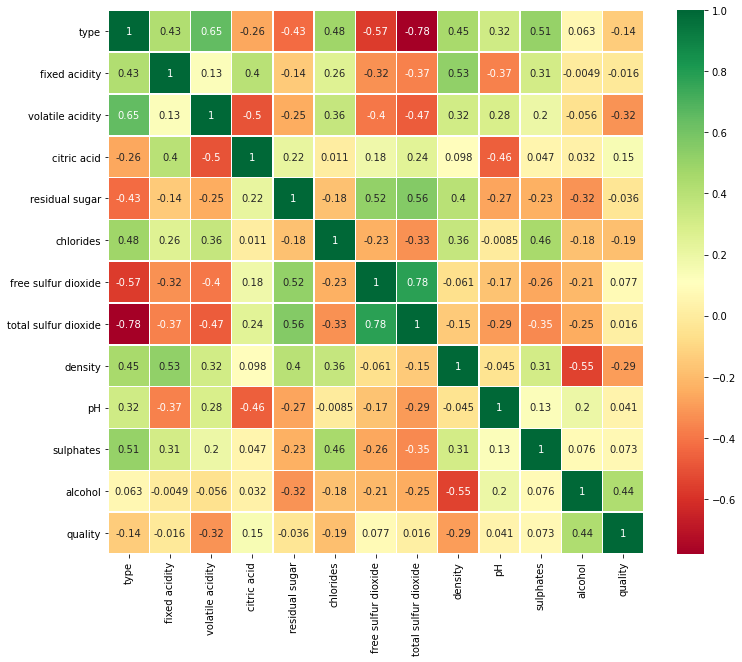

In [0]:
import seaborn as sns

sns.heatmap(
    train[
          ['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']
          ].corr(), annot=True, cmap='RdYlGn', linewidths=0.5
)
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.show()

The most notable variables are total sulfur dioxide, and volitile acidity, so we'll definitely use those.  Free sulfur dixoide, fixed acidity, residual sugar, chlorides, density, and sulphates are also reasonably highly correlated.  We'll probably use those as well.


I'm going to describe those features to see if we need to do anything to the data before we begin our training.


--START HIGHLY CORRELATED--

In [0]:
train['total sulfur dioxide'].describe()

count    3198.000000
mean       95.106160
std        62.319165
min         6.000000
25%        37.000000
50%        90.000000
75%       144.000000
max       366.500000
Name: total sulfur dioxide, dtype: float64

In [0]:
train['volatile acidity'].describe()

count    3198.000000
mean        0.404015
std         0.191543
min         0.080000
25%         0.250000
50%         0.360000
75%         0.540000
max         1.580000
Name: volatile acidity, dtype: float64

--START LESS CORRELATED--

In [0]:
train['free sulfur dioxide'].describe()

count    3198.000000
mean       25.385241
std        16.734807
min         1.000000
25%        12.000000
50%        22.000000
75%        35.000000
max       131.000000
Name: free sulfur dioxide, dtype: float64

In [0]:
train['fixed acidity'].describe()

count    3198.000000
mean        7.668293
std         1.525136
min         4.600000
25%         6.700000
50%         7.300000
75%         8.200000
max        15.900000
Name: fixed acidity, dtype: float64

In [0]:
train['residual sugar'].describe()

count    3198.000000
mean        4.292917
std         4.067826
min         0.800000
25%         1.800000
50%         2.300000
75%         5.300000
max        22.000000
Name: residual sugar, dtype: float64

In [0]:
train['chlorides'].describe()

count    3198.000000
mean        0.066953
std         0.042392
min         0.012000
25%         0.043000
50%         0.059000
75%         0.080000
max         0.611000
Name: chlorides, dtype: float64

In [0]:
train['density'].describe()

count    3198.000000
mean        0.995568
std         0.002602
min         0.988600
25%         0.993625
50%         0.995800
75%         0.997440
max         1.003690
Name: density, dtype: float64

In [0]:
train['sulphates'].describe()

count    3198.000000
mean        0.572802
std         0.168364
min         0.250000
25%         0.460000
50%         0.550000
75%         0.650000
max         2.000000
Name: sulphates, dtype: float64

Free sulfur dioxide and residual sugar look like they have a pretty extreme outlier, so I'm going to look at those features a little closer - everything else seems fine as is

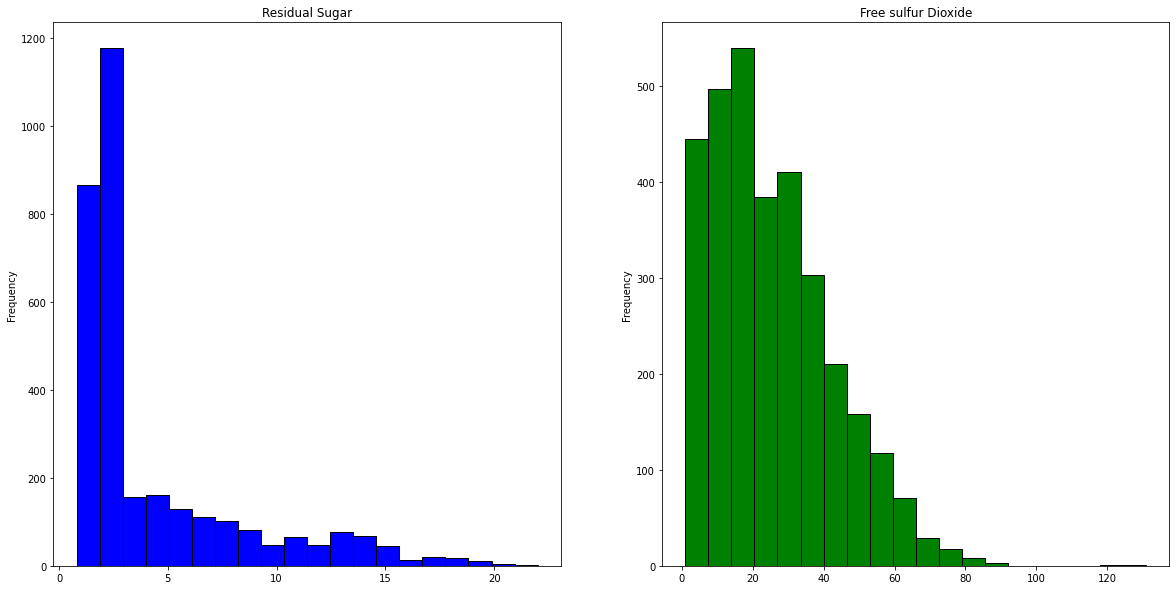

In [0]:
f, ax=plt.subplots(1,2,figsize=(20,10))
train['residual sugar'].plot.hist(ax=ax[0],bins=20,edgecolor='black',color='blue')
ax[0].set_title('Residual Sugar')
train['free sulfur dioxide'].plot.hist(ax=ax[1],bins=20,edgecolor='black',color='green')
ax[1].set_title('Free sulfur Dioxide')
plt.show()

The free sulfur dioxide graph does appear to have a couple notable outliers as I expected.  The residual sugar seems to have about half the data bunched up at the beginning, so I'm assuming thats most of, if not all of, the red wine because there's a negative correlation between the residual sugar and type (type1 = red, type0 = white).  Residual sugar should still be good for us to use.

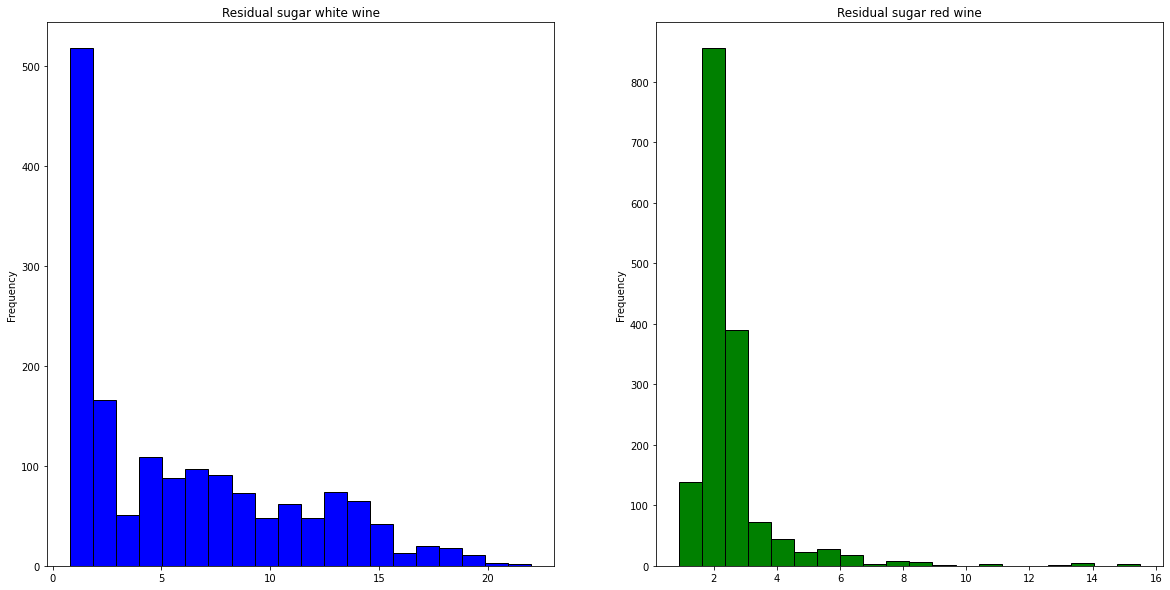

In [0]:
#plot residual sugar against type histogram
f, ax=plt.subplots(1,2,figsize=(20,10))
train[train['type']==0]['residual sugar'].plot.hist(ax=ax[0],bins=20,edgecolor='black',color='blue')
ax[0].set_title('Residual sugar white wine')
train[train['type']==1]['residual sugar'].plot.hist(ax=ax[1],bins=20,edgecolor='black',color='green')
ax[1].set_title('Residual sugar red wine')
plt.show()

What I suspected from the first graph seems to be partially true: less extreme than I was expecting because there's a decent amount of white wine with very little residual sugar

In [0]:
red['residual sugar'].describe()

count    1599.000000
mean        2.538806
std         1.409928
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64

In [0]:
train.loc[train['free sulfur dioxide']>100]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
325,7.5,0.27,0.31,5.8,0.057,131.0,313.0,0.9946,3.18,0.59,10.5,5,0
659,6.8,0.29,0.16,1.4,0.038,122.5,234.5,0.9922,3.15,0.47,10.0,4,0


Because there are only 2 outliers for the free sulfur dioxide, I'm going to drop them to avoid any potential issues

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3198 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3198 non-null   float64
 1   volatile acidity      3198 non-null   float64
 2   citric acid           3198 non-null   float64
 3   residual sugar        3198 non-null   float64
 4   chlorides             3198 non-null   float64
 5   free sulfur dioxide   3198 non-null   float64
 6   total sulfur dioxide  3198 non-null   float64
 7   density               3198 non-null   float64
 8   pH                    3198 non-null   float64
 9   sulphates             3198 non-null   float64
 10  alcohol               3198 non-null   float64
 11  quality               3198 non-null   int64  
 12  type                  3198 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 349.8 KB


In [0]:
train = train[train['free sulfur dioxide'] < 100]

Now there should be no rows returned by the next command

In [0]:
train.loc[train['free sulfur dioxide']>100]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


In [0]:
train['free sulfur dioxide'].describe()

count    3196.000000
mean       25.321809
std        16.546357
min         1.000000
25%        12.000000
50%        22.000000
75%        35.000000
max        88.000000
Name: free sulfur dioxide, dtype: float64

I'm also going to look at the graphs for the 2 most correlated features (total sulfur dioxide and volatile acidity) because they're going to be important for our predictions

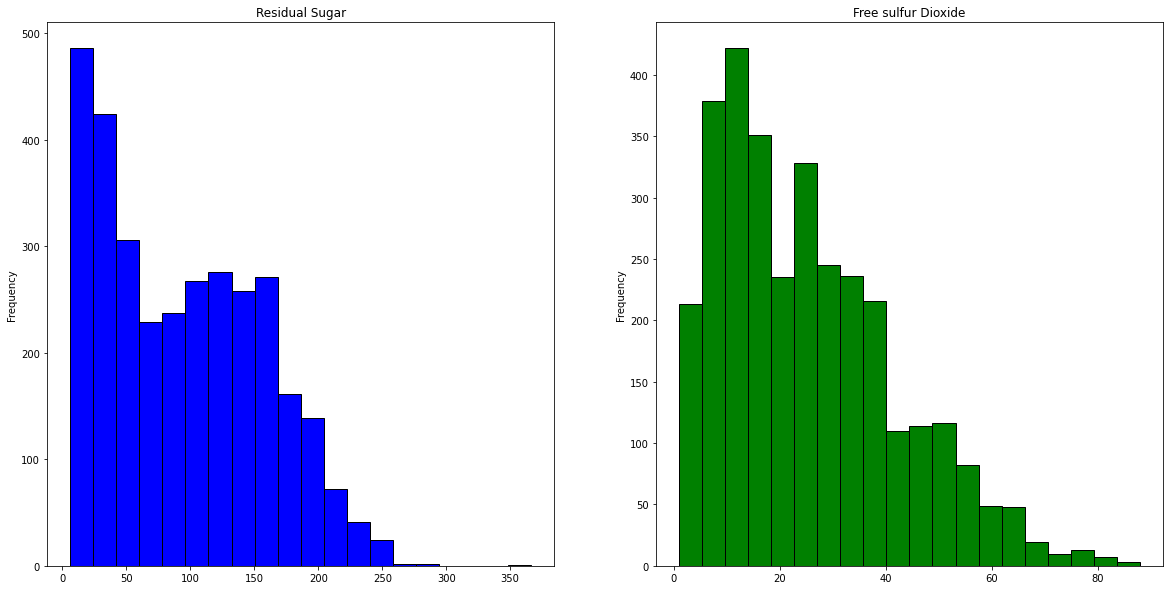

In [0]:
f, ax=plt.subplots(1,2,figsize=(20,10))
train['total sulfur dioxide'].plot.hist(ax=ax[0],bins=20,edgecolor='black',color='blue')
ax[0].set_title('Residual Sugar')
train['free sulfur dioxide'].plot.hist(ax=ax[1],bins=20,edgecolor='black',color='green')
ax[1].set_title('Free sulfur Dioxide')
plt.show()

Now I'm going to drop the features we don't need for training

In [0]:
train.drop(['citric acid','pH','alcohol','quality'], axis=1, inplace=True)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3196 entries, 0 to 1598
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3196 non-null   float64
 1   volatile acidity      3196 non-null   float64
 2   residual sugar        3196 non-null   float64
 3   chlorides             3196 non-null   float64
 4   free sulfur dioxide   3196 non-null   float64
 5   total sulfur dioxide  3196 non-null   float64
 6   density               3196 non-null   float64
 7   sulphates             3196 non-null   float64
 8   type                  3196 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 249.7 KB


Now we can train a model - I'm going to use the Bagging Classifier with KNeighbors

First we need to split our data into training and testing sets

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix


X=train[train.columns[1:]]
Y=train['type']

train,test=train_test_split(train,test_size=0.3,random_state=0,stratify=train['type'])

train_X=train[train.columns[:8]]
train_Y=train[train.columns[8:]]
test_X=test[test.columns[:8]]
test_Y=test[test.columns[8:]]

In [0]:
#model = RandomForestClassifier(n_estimators=100)

model = BaggingClassifier(KNeighborsClassifier(),max_samples=0.4,max_features=0.4)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print(metrics.accuracy_score(prediction,test_Y))

0.9702127659574468


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cross validation with K folds

In [0]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

kfold = KFold(n_splits=10)
cval_result = cross_val_score(model,X,Y, cv = kfold,scoring = 'accuracy')
print('mean:',cval_result.mean())
print('std:',cval_result.std())

mean: 0.9642128041809569
std: 0.019626840702414043


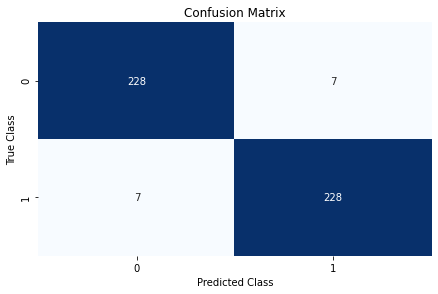

In [0]:
cm = pd.DataFrame(confusion_matrix(test_Y,prediction))
sns.heatmap(cm, annot=True, cbar=None, cmap='Blues',fmt='2.0f')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [0]:
from sklearn.model_selection import GridSearchCV

n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.0
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   38.4s finished
